In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import gpflow as gpf
from gpflow import set_trainable
from gpflow.ci_utils import reduce_in_tests
gpf.config.set_default_float(np.float64)
gpf.config.set_default_jitter(1e-4)
gpf.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpf.utilities.to_default_float

tf.random.set_seed(123)

### Some default settings.

      0         1
0  1896  4.470833
1  1900  4.464729
2  1904  5.222083
3  1908  4.154679
4  1912  3.903317


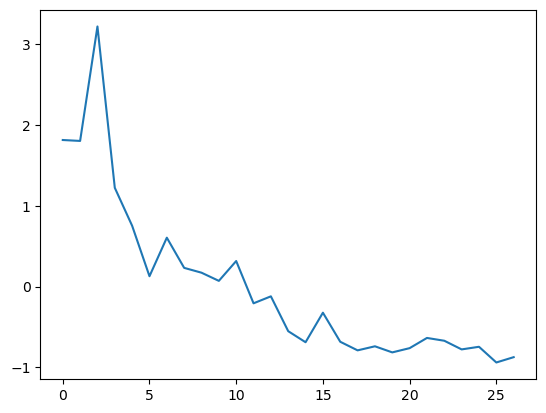

In [4]:
import numpy as np
import pandas as pd

data = pd.read_csv("/home/janneke/ods_data_cache/olympic_marathon_men/olympicMarathonTimes.csv", header=None)
print(data.head())
X = data[0].to_numpy().reshape(-1, 1).astype(float)
y = data[1].to_numpy().reshape(-1, 1)

offset = y.mean()
scale = np.sqrt(y.var())
yhat = (y - offset)/scale
plt.plot(yhat)

### Define (conjugate) model, priors

In [21]:
kernel = gpf.kernels.RBF() + gpf.kernels.Constant(2)
model = gpf.models.GPMC((X, yhat), kernel = kernel, likelihood=gpf.likelihoods.StudentT())

model.kernel.kernels[0].lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[0].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[1].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))

model.likelihood.scale.prior = tfd.Gamma(f64(1.0), f64(1.0))
optimizer = gpf.optimizers.Scipy()
maxiter = reduce_in_tests(3000)
optimizer.minimize(
    model.training_loss,
    model.trainable_variables,
    options=dict(maxiter=maxiter),
)
model

name,class,transform,prior,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.19268
GPMC.kernel.kernels[0].lengthscales,Parameter,Softplus,Gamma,True,(),float64,0.33649
GPMC.kernel.kernels[1].variance,Parameter,Softplus,Gamma,True,(),float64,0.4367
GPMC.likelihood.scale,Parameter,Softplus + Shift,Gamma,True,(),float64,0.0
GPMC.V,Parameter,Identity,Normal,True,"(27, 1)",float64,[[1.26616...


Run the sampling. To edit the HMC kernel parameters, at this point just editing the sampling.py file is easiest. By default, a single MCMC step is done, and 10 integration steps, which on my machine takes 7 minutes or so.

In [35]:
num_burnin_steps = reduce_in_tests(600)
num_samples = reduce_in_tests(1000)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpf.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn,
    num_leapfrog_steps=50,
    step_size=0.01,
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc,
    num_adaptation_steps=10,
    target_accept_prob=f64(0.75),
    adaptation_rate=0.1,
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, _ = run_chain_fn()


If we do not take that many MCMC steps, we don't find much, unfortunately:

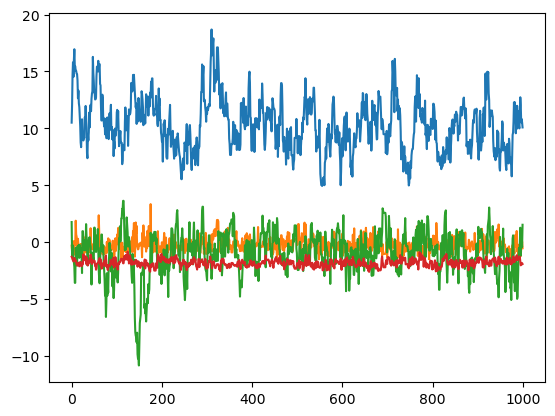

In [36]:
for sample in samples[1:]:
    plt.plot(sample)

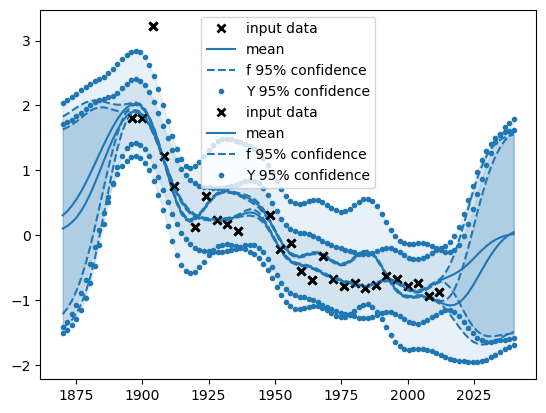

In [39]:
Xtest = np.linspace(1870, 2040, 100)[:, None]
f_samples = []

for i in range(0, num_samples, 500):
    # Note that hmc_helper.current_state contains the unconstrained variables
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f_mean, f_var = model.predict_f(Xtest, full_cov=False)
    y_mean, y_var = model.predict_y(Xtest)
    f_lower = f_mean - 1.96 * np.sqrt(f_var)
    f_upper = f_mean + 1.96 * np.sqrt(f_var)
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)
    
    plt.plot(X, yhat, "kx", mew=2, label="input data")
    plt.plot(Xtest, f_mean, "-", color="C0", label="mean")
    plt.plot(Xtest, f_lower, "--", color="C0", label="f 95% confidence")
    plt.plot(Xtest, f_upper, "--", color="C0")
    plt.fill_between(
        Xtest[:, 0], f_lower[:, 0], f_upper[:, 0], color="C0", alpha=0.1
    )
    plt.plot(Xtest, y_lower, ".", color="C0", label="Y 95% confidence")
    plt.plot(Xtest, y_upper, ".", color="C0")
    plt.fill_between(
        Xtest[:, 0], y_lower[:, 0], y_upper[:, 0], color="C0", alpha=0.1
    )
    plt.legend()


plt.plot(X, yhat, "kx")

In [24]:
rate_samples = np.exp(f_samples[:, :, 0])

(line,) = plt.plot(Xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(
    Xtest[:, 0],
    np.percentile(rate_samples, 5, axis=0),
    np.percentile(rate_samples, 95, axis=0),
    color=line.get_color(),
    alpha=0.2,
)

plt.plot(X, yhat, "kx", mew=2)
plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)))



TypeError: list indices must be integers or slices, not tuple